In [14]:
from utils2 import *
import random,time
import numpy
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

plt.rcParams.update({'font.size': 20})


In [2]:
x_train, y_train, x_gallery, y_gallery, x_probe, y_probe = load_data('data/Q2/Q2')

x_train = (resize(x_train, (64, 32)))
x_gallery = (resize(x_gallery, (64, 32)))
x_probe = (resize(x_probe, (64, 32)))

print(x_train.shape)
print(y_train.shape)
print(x_gallery.shape)
print(y_gallery.shape)
print(x_probe.shape)
print(y_probe.shape)

# flatten data
x_train_flat = vectorise(x_train)
x_gallery_flat = vectorise(x_gallery)
x_probe_flat = vectorise(x_probe)

print(x_train_flat.shape)
print(len(numpy.unique(y_train)))

(5933, 64, 32, 3)
(5933,)
(301, 64, 32, 3)
(301,)
(301, 64, 32, 3)
(301,)
(5933, 6144)
300


In [3]:
# numpy.random.seed(4)
# test_frames = numpy.array(()).astype('int')
# for i in numpy.unique(y_train):    
#     indexes = numpy.where(y_train == i)[0]
#     count = len(indexes);
#     f = numpy.random.randint(count, size=6)
#     test_frames = numpy.append(test_frames, indexes[f])

# train_fea = fea
# train_gnd = gnd
# train_fea = numpy.delete(train_fea, test_frames, 0)
# train_gnd = numpy.delete(train_gnd, test_frames, 0)
# test_fea = fea[test_frames, :]
# test_gnd = gnd[test_frames, :]
from sklearn.model_selection import train_test_split
x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(x_train_.shape, y_train_.shape)
print(x_val.shape, y_val.shape)


(4746, 64, 32, 3) (4746,)
(1187, 64, 32, 3) (1187,)


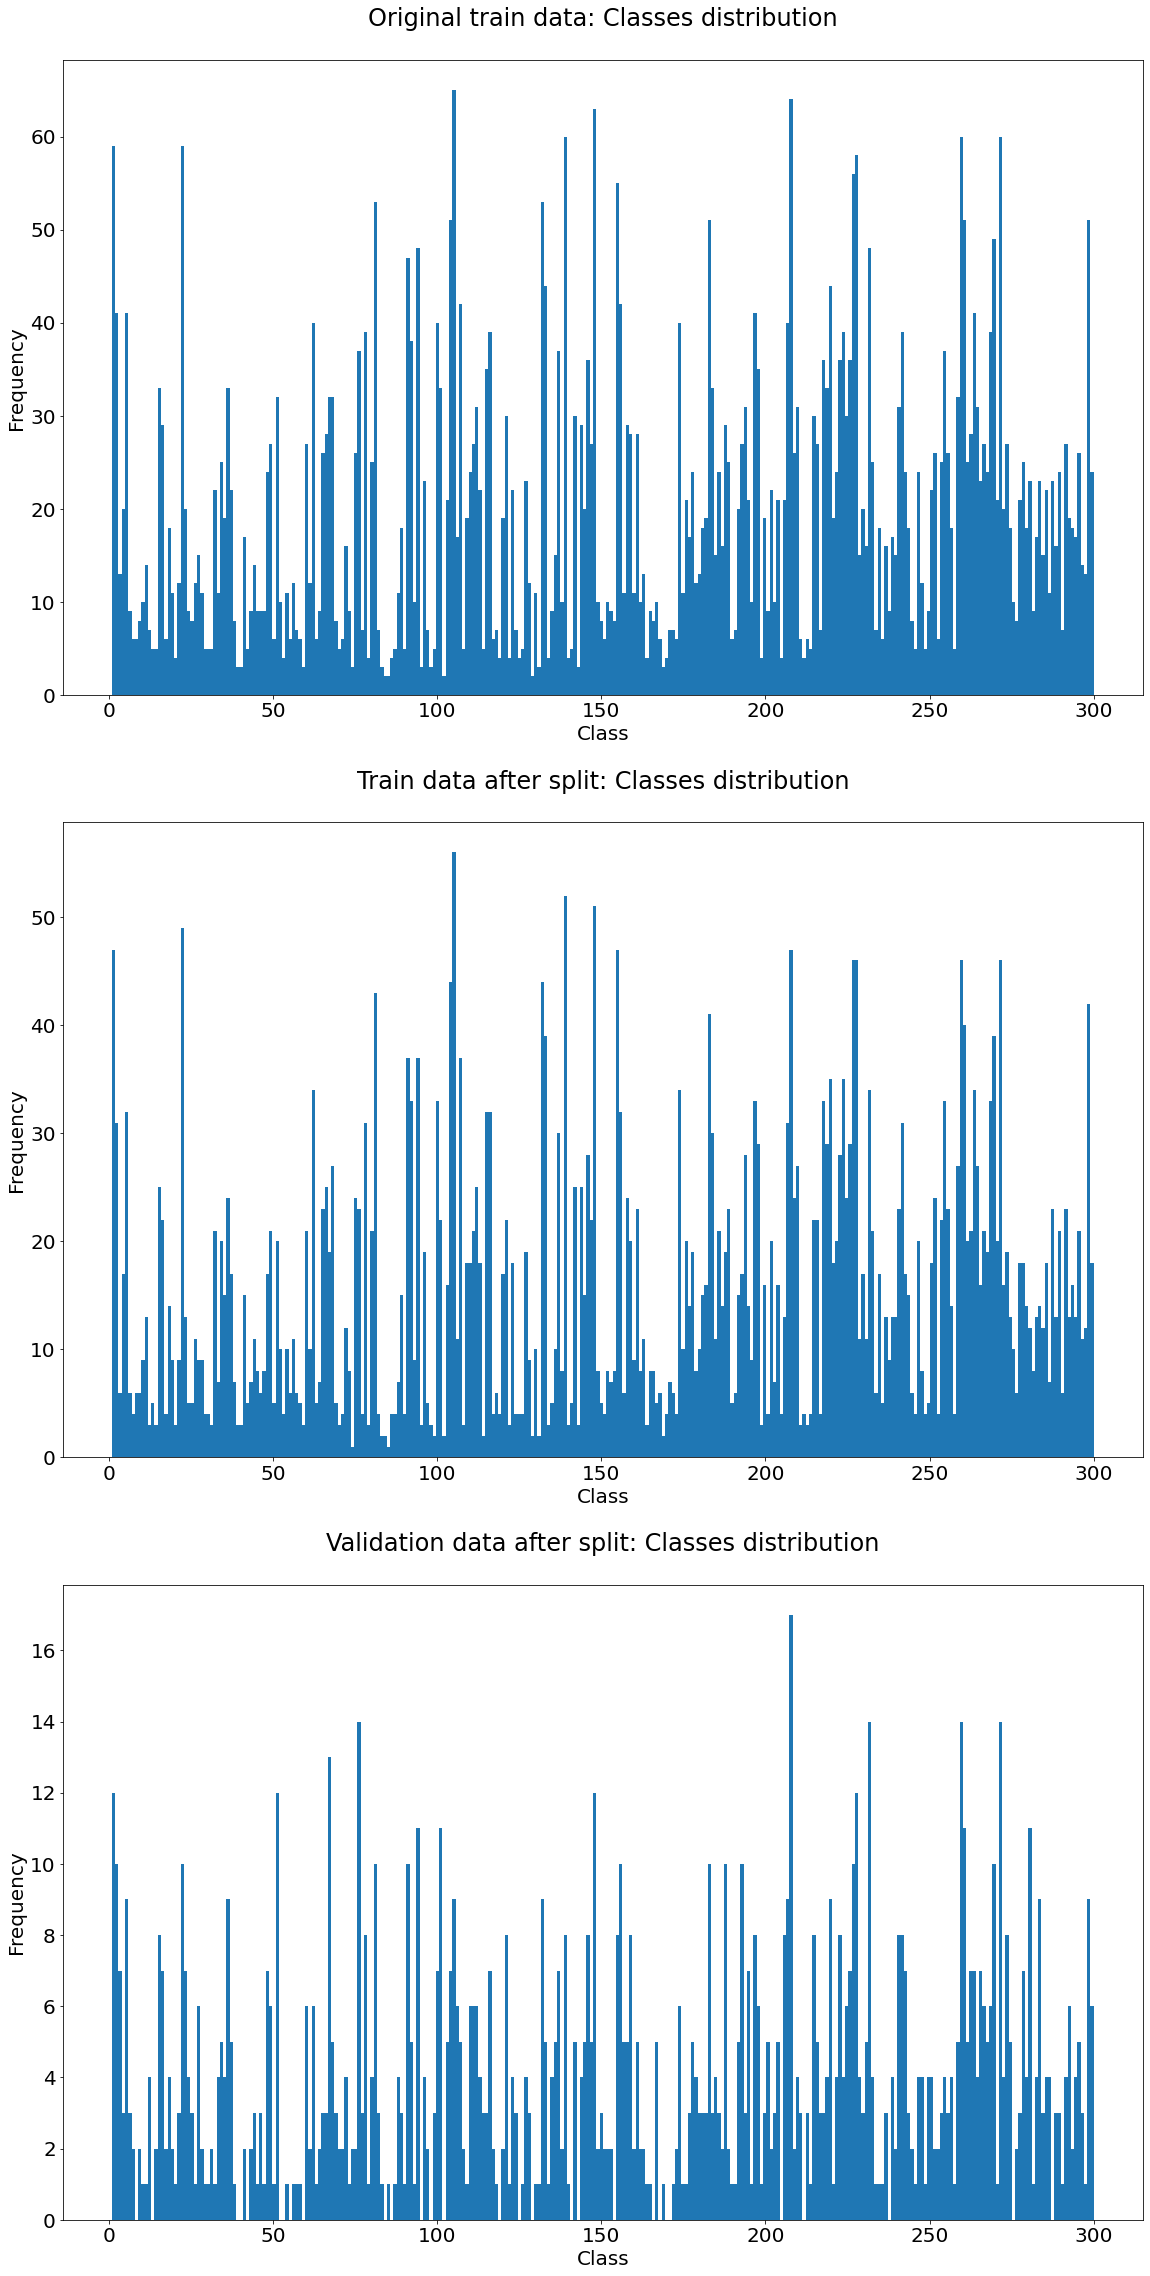

In [22]:
fig = plt.figure(figsize=[15,15])
plt.subplots_adjust(left=0, right=1, top=1.5, bottom=-0.5)

ax = fig.add_subplot(3, 1, 1)
ax.hist(y_train,300);
ax.set_title('Original train data: Classes distribution\n');
ax.set_xlabel('Class')
ax.set_ylabel('Frequency');

ax = fig.add_subplot(3, 1, 2)
ax.hist(y_train_,300);
ax.set_title('Train data after split: Classes distribution\n');
ax.set_xlabel('Class')
ax.set_ylabel('Frequency');

ax = fig.add_subplot(3, 1, 3)
ax.hist(y_val,300);
ax.set_title('Validation data after split: Classes distribution\n');
ax.set_xlabel('Class')
ax.set_ylabel('Frequency');

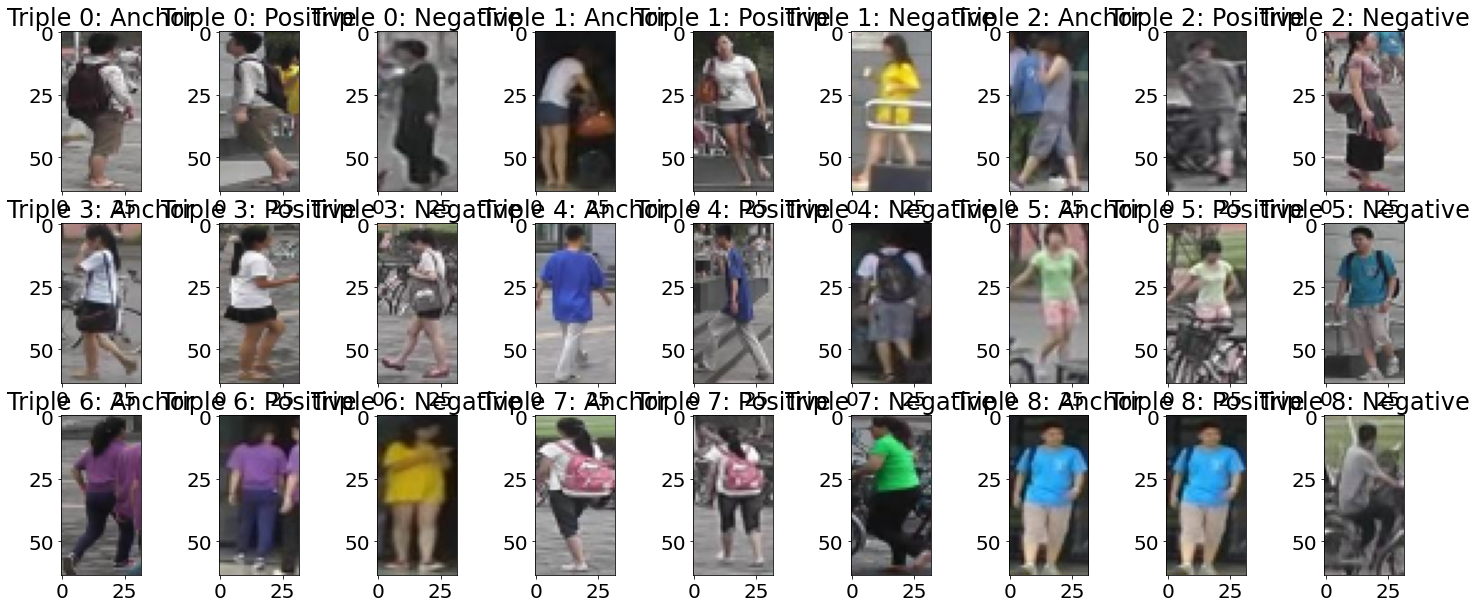

In [16]:
# create a triplet and display a triplet
triplet_test = triplet_generator(x_train, y_train, 9)
x, _ = next(triplet_test)
plot_triplets(x)

In [6]:
import sys
sys.modules.pop('utils2')
from utils2 import *

In [24]:
my_base_network(32).summary()

Model: "SiameseBranch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 32, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 32, 8)         224       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 32, 8)         584       
_________________________________________________________________
batch_normalization_12 (Batc (None, 64, 32, 8)         32        
_________________________________________________________________
activation_12 (Activation)   (None, 64, 32, 8)         0         
_________________________________________________________________
spatial_dropout2d_9 (Spatial (None, 64, 32, 8)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 16, 8)       

In [7]:
triplet_network = my_triplet_network()
# keras.utils.plot_model(triplet_network, show_shapes=True)
triplet_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor (InputLayer)             [(None, 64, 32, 3)]  0                                            
__________________________________________________________________________________________________
Positive (InputLayer)           [(None, 64, 32, 3)]  0                                            
__________________________________________________________________________________________________
Negative (InputLayer)           [(None, 64, 32, 3)]  0                                            
__________________________________________________________________________________________________
SiameseBranch (Functional)      (None, 32)           1076488     Anchor[0][0]                     
                                                                 Positive[0][0]               

In [ ]:
batch_size = 128
training_gen = triplet_generator(x_train_, y_train_, batch_size)
triplet_val = get_triplet_data(x_val, y_val, x_val.shape[0])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

##############
run_number = 3
##############


try: 
    triplet_network = keras.models.load_model("data/Q2_trained_triplet_model_"+str(run_number))
    history = loaddata("Q2", "triplet_training_history_"+str(run_number))
except:
    NAME = "deep"
    triplet_network = my_triplet_network()
    triplet_network.compile(optimizer=keras.optimizers.Adam())

    checkpoint = ModelCheckpoint("data/Q2_trained_triplet_model_"+str(run_number), verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
    callback = EarlyStopping(monitor='val_loss', patience=5)
    
    history = triplet_network.fit(training_gen, steps_per_epoch = x_train_.shape[0] // batch_size, 
                                epochs=100, validation_data=(triplet_val, None),
                                callbacks=[callback, checkpoint])
    # triplet_network.save("data/Q2_trained_triplet_model")
    savedata(history.history, 'Q2', "triplet_training_history_"+str(run_number))

# Training time: 17'44s
# Training time 3: epoch 43, 21'37s



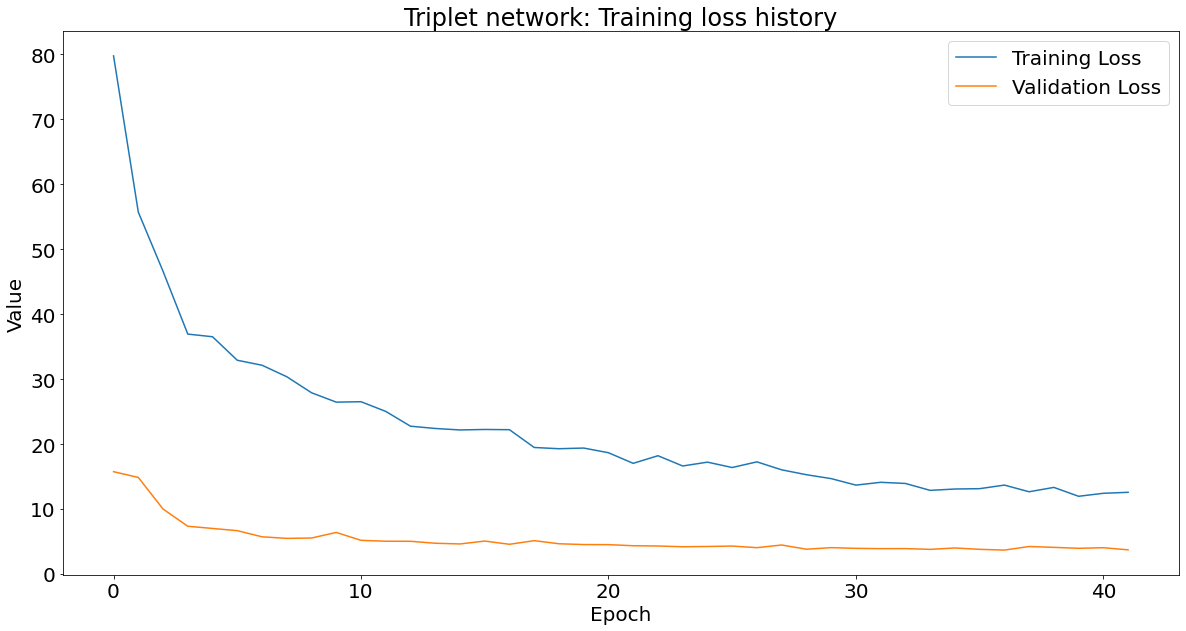

In [13]:
def plot_triplet_training(history):
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history['loss'], label="Training Loss")
    ax.plot(history['val_loss'], label="Validation Loss")
    ax.set_title('Triplet network: Training loss history');
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value');
    ax.legend()
    plt.savefig(f"Q2_triplet_training_history_"+str(run_number))


history = loaddata("Q2", "triplet_training_history_"+str(run_number))
plot_triplet_training(history)

PCA Top-1: 25.25%
PCA Top-5: 50.50%
PCA Top-10: 64.12%
PCA Final value: 100.00%


'\nPCA Top-1: 23.59%\nPCA Top-5: 53.16%\nPCA Top-10: 68.44%\nPCA Final value: 100.00%\n'

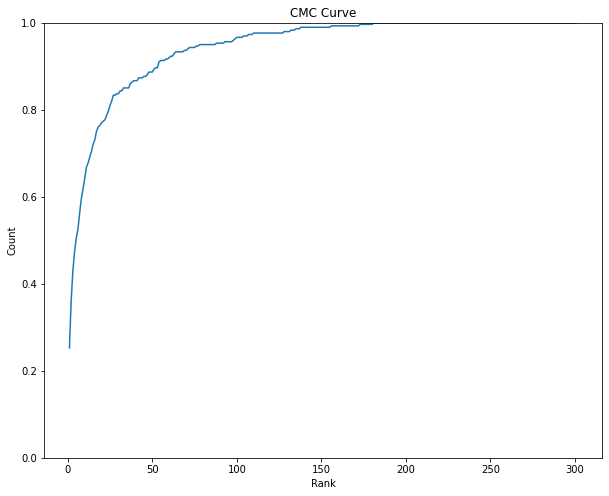

In [9]:
triplet_network = keras.models.load_model("data/Q2_trained_triplet_model")

transform_layer = triplet_network.get_layer("SiameseBranch")
x_gallery_transformed = transform_layer.predict(x_gallery)
x_probe_transformed = transform_layer.predict(x_probe)

ranked_hist = get_ranked_histogram_l2_distance(x_gallery_transformed, y_gallery, x_probe_transformed, y_probe)
cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(cmc)

method_name = "PCA"
print(f"{method_name} Top-1: {cmc[0]*100:.2f}%")
print(f"{method_name} Top-5: {(cmc[4])*100:.2f}%")
print(f"{method_name} Top-10: {(cmc[9])*100:.2f}%")
print(f"{method_name} Final value: {(cmc[-1])*100:.2f}%")

'''
PCA Top-1: 23.59%
PCA Top-5: 53.16%
PCA Top-10: 68.44%

Inference time: 2.5 s
'''

PCA Top-1: 24.58%
PCA Top-5: 56.15%
PCA Top-10: 68.77%
PCA Final value: 100.00%


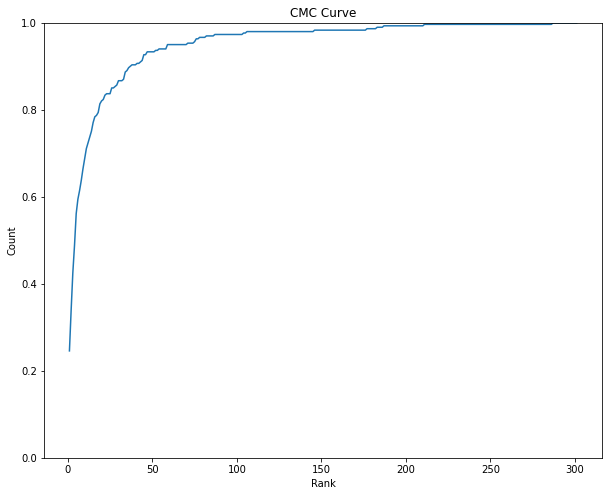

In [ ]:
# ranked_hist = get_ranked_histogram_cos_distance(x_gallery_transformed, y_gallery, x_probe_transformed, y_probe)
# cmc = ranked_hist_to_CMC(ranked_hist)
# plot_cmc(cmc)

# method_name = "PCA"
# print(f"{method_name} Top-1: {cmc[0]*100:.2f}%")
# print(f"{method_name} Top-5: {(cmc[4])*100:.2f}%")
# print(f"{method_name} Top-10: {(cmc[9])*100:.2f}%")
# print(f"{method_name} Final value: {(cmc[-1])*100:.2f}%")

In [ ]:
def ComputeDistance(x, y):
    x = K.l2_normalize(x, axis=1)
    y = K.l2_normalize(y, axis=1)
    dist = K.sum(K.square(x - y), axis=-1)
    return dist


anchor_embedding = transform_layer.predict(triplet_val[0])
positive_embedding = transform_layer.predict(triplet_val[1])
negative_embedding = transform_layer.predict(triplet_val[2])

positive_distances = ComputeDistance(anchor_embedding, positive_embedding)
negative_distances = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Triplet network: Distance distribution');
ax.set_xlabel('Value')
ax.set_ylabel('Frequency');
ax.hist(positive_distances, numpy.arange(0, 4.0, 0.1), histtype='barstacked', label='Positive Pairs', fc=(0, 0, 1.0, 0.5))
ax.hist(negative_distances, numpy.arange(0, 4.0, 0.1), histtype='barstacked', label='Negative Pairs', fc=(1.0, 0.75, 0, 0.5))
ax.legend();
plt.savefig("Q2_Triplet_network_Distance_distribution")